## Download the Data

In [1]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) &&   mv kaggle.json ~/.kaggle/ && echo 'Done'

Done


In [2]:
! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 60% 9.00M/15.1M [00:00<00:00, 30.7MB/s]
100% 15.1M/15.1M [00:00<00:00, 43.5MB/s]


In [3]:
! unzip '/content/brain-mri-images-for-brain-tumor-detection.zip'

Archive:  /content/brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tum

## Setting Up Environment

In [4]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Recall

import matplotlib.image as mpimg
import random

init_notebook_mode(connected=True)
RANDOM_SEED = 42

## Split the Data

In [5]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (90.7 kB/s)
Selecting previously unselected package tree.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
.
├── brain_tumor_dataset
│   ├── no
│   └── yes
├── no
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── VAL
│   ├── NO
│   └── YES
└── yes

15 directories


In [6]:
IMG_PATH = '/content/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

## Importing and Preprocessing

In [7]:
def load_data(dir_path, img_size=(100,100)):
  """
  Load resized images as np.arrays to workspace
  """
  X = []
  y = []
  i = 0
  labels = dict()
  for path in tqdm(sorted(os.listdir(dir_path))):
      if not path.startswith('.'):
          labels[i] = path
          for file in os.listdir(dir_path + path):
              if not file.startswith('.'):
                  img = cv2.imread(dir_path + path + '/' + file)
                  X.append(img)
                  y.append(i)
          i += 1
  X = np.array(X)
  y = np.array(y)
  print(f'{len(X)} images loaded from {dir_path} directory.')
  return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  plt.figure(figsize = (6,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  cm = np.round(cm,2)
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [8]:
TRAIN_DIR = '/content/TRAIN/'
TEST_DIR = '/content/TEST/'
VAL_DIR = '/content/VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



193 images loaded from /content/TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 78.86it/s]


10 images loaded from /content/TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 12.45it/s]

50 images loaded from /content/VAL/ directory.


Image shape: (325, 300)


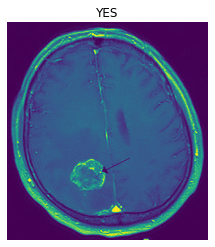

In [9]:
img = view_random_image(target_dir=TRAIN_DIR,
                        target_class='YES')

In [10]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

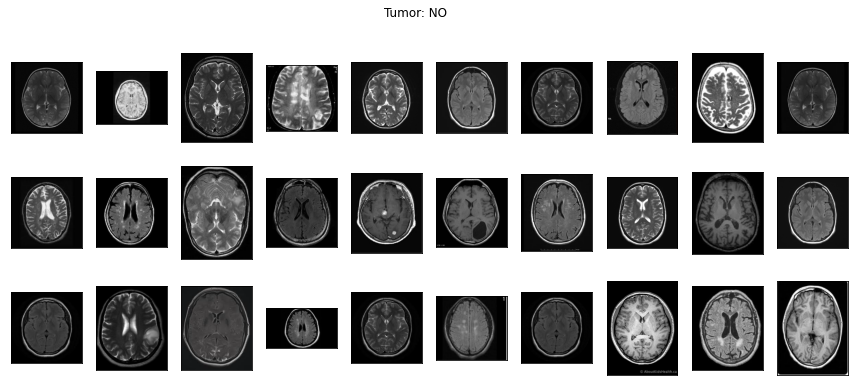

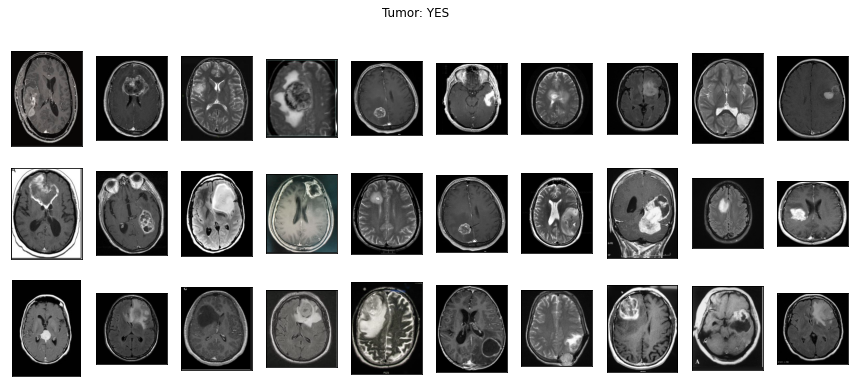

In [11]:
plot_samples(X_train, y_train, labels, 30)

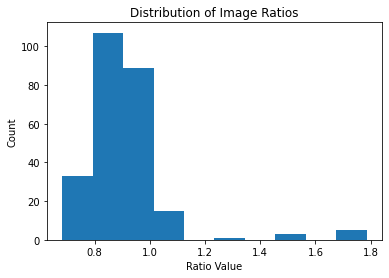

In [12]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

### Cropping the Images

In [13]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [14]:
img = cv2.imread('/content/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

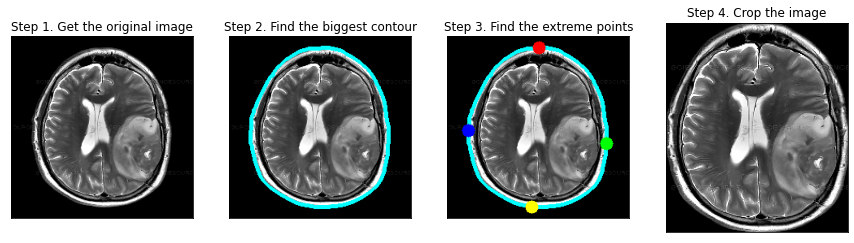

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [16]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



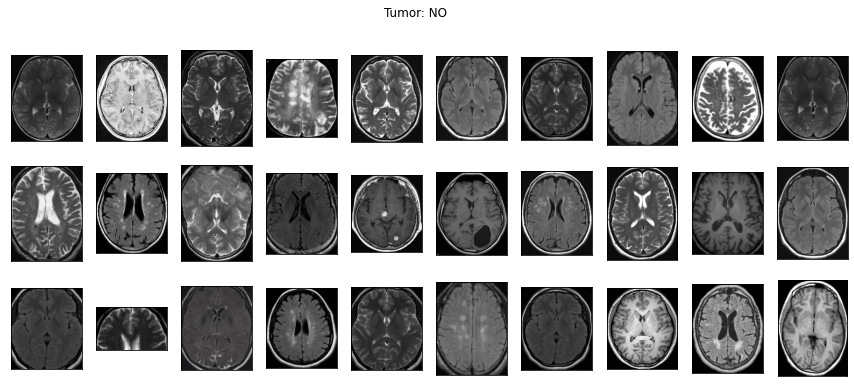

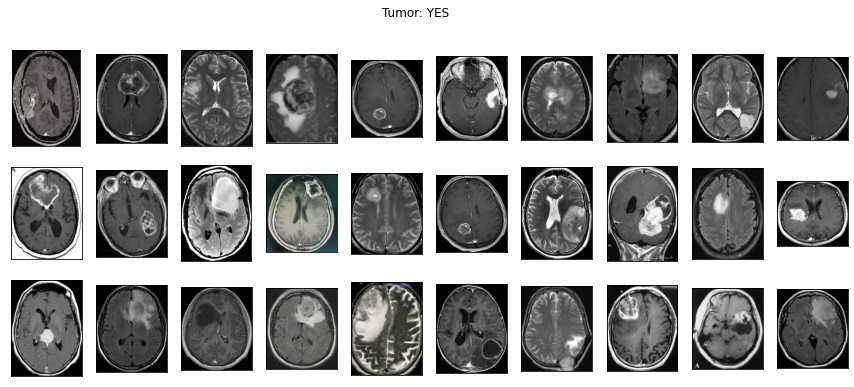

In [17]:
plot_samples(X_train_crop, y_train, labels, 30)

In [18]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [19]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

### Resizing the image

In [20]:
def preprocess_imgs(set_name, img_size): # function to resize the image
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [21]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

### Data Augmentation

In [22]:
# set the parameters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [23]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

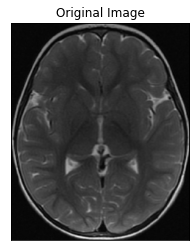

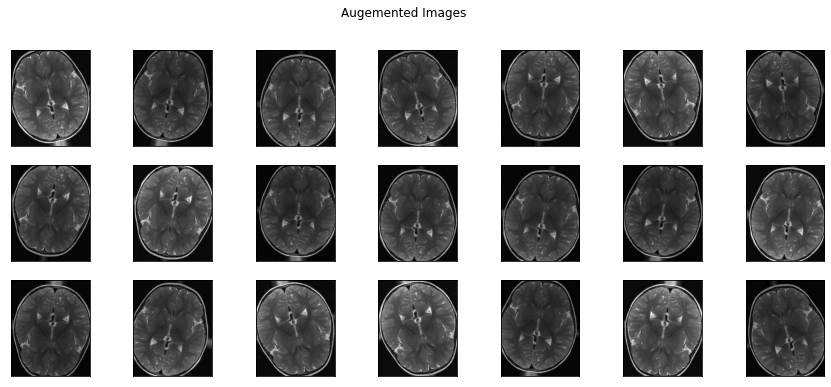

In [24]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [25]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
)

valid_datagen = ImageDataGenerator(
    rescale=1/255.,
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Modelling

In [151]:
import matplotlib.pyplot as plt
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### Base Model

In [152]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
base_model = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3,)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])
# Compile the model
base_model.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [153]:
base_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_13 (Flatten)         (None, 475240)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [154]:
EPOCHS = 100
es = EarlyStopping(
    patience=10
)
base_mc = ModelCheckpoint(
    "base_model.h5", 
    save_best_only=True,
    monitor="val_loss",
)
vgg_mc = ModelCheckpoint(
    "vgg_model.h5", 
    save_best_only=True,
    monitor="val_loss",
)
resnet_mc = ModelCheckpoint(
    "resnet_model.h5", 
    save_best_only=True,
    monitor="val_loss",
)
efficient_mc = ModelCheckpoint(
    "efficient_model.h5", 
    save_best_only=True,
    monitor="val_loss",
)

In [155]:
step = int(193/16)
val_step = int(50/16)

In [156]:
# Fit the model
base_model_history = base_model.fit(
                        train_generator,
                        steps_per_epoch=step,
                        epochs=EPOCHS,
                        validation_data=validation_generator,
                        validation_steps=val_step,
                        callbacks=[es, base_mc]
                    )

Epoch 1/100
12/12 [==============================] - 4s 342ms/step - loss: 1.5499 - accuracy: 0.5424 - val_loss: 0.6547 - val_accuracy: 0.6250
Epoch 2/100
12/12 [==============================] - 4s 294ms/step - loss: 0.6768 - accuracy: 0.6384 - val_loss: 0.6596 - val_accuracy: 0.6042
Epoch 3/100
12/12 [==============================] - 3s 288ms/step - loss: 0.6623 - accuracy: 0.6271 - val_loss: 0.6481 - val_accuracy: 0.6042
Epoch 4/100
12/12 [==============================] - 3s 288ms/step - loss: 0.6769 - accuracy: 0.6610 - val_loss: 0.6249 - val_accuracy: 0.7500
Epoch 5/100
12/12 [==============================] - 3s 288ms/step - loss: 0.6755 - accuracy: 0.6328 - val_loss: 0.6365 - val_accuracy: 0.7500
Epoch 6/100
12/12 [==============================] - 3s 283ms/step - loss: 0.6637 - accuracy: 0.6045 - val_loss: 0.5856 - val_accuracy: 0.7292
Epoch 7/100
12/12 [==============================] - 3s 290ms/step - loss: 0.6618 - accuracy: 0.6328 - val_loss: 0.5430 - val_accuracy: 0.7292

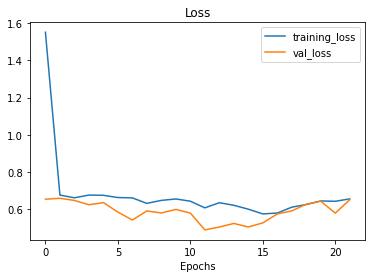

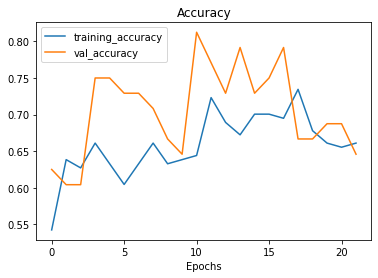

In [157]:
plot_loss_curves(base_model_history)

### Transfer Learning

we are going to use VGG-16, ResNet50V2, and also EfficientNetB0

In [178]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

#### VGG-16

In [179]:
# load base model
base_model = VGG16(
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [180]:
vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())


vgg_model.add(layers.Dense(1, activation='sigmoid'))
vgg_model.layers[0].trainable = False

vgg_model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

vgg_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [181]:
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=step,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=val_step,
    callbacks=[es, vgg_mc]
)

Epoch 1/100
12/12 [==============================] - 5s 395ms/step - loss: 0.6704 - accuracy: 0.6215 - val_loss: 0.6237 - val_accuracy: 0.6667
Epoch 2/100
12/12 [==============================] - 4s 329ms/step - loss: 0.6221 - accuracy: 0.6328 - val_loss: 0.6055 - val_accuracy: 0.6042
Epoch 3/100
12/12 [==============================] - 4s 326ms/step - loss: 0.6083 - accuracy: 0.6667 - val_loss: 0.5897 - val_accuracy: 0.7292
Epoch 4/100
12/12 [==============================] - 4s 323ms/step - loss: 0.5889 - accuracy: 0.6893 - val_loss: 0.6181 - val_accuracy: 0.6042
Epoch 5/100
12/12 [==============================] - 4s 330ms/step - loss: 0.5839 - accuracy: 0.7119 - val_loss: 0.5202 - val_accuracy: 0.7917
Epoch 6/100
12/12 [==============================] - 4s 328ms/step - loss: 0.5620 - accuracy: 0.6949 - val_loss: 0.5060 - val_accuracy: 0.8333
Epoch 7/100
12/12 [==============================] - 4s 324ms/step - loss: 0.5333 - accuracy: 0.7401 - val_loss: 0.5076 - val_accuracy: 0.7917

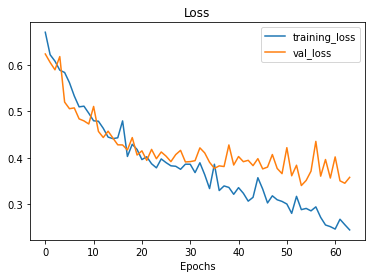

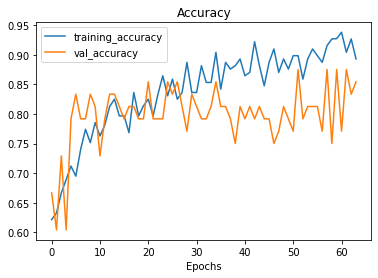

In [182]:
plot_loss_curves(vgg_history)

#### Resnet

In [183]:
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
)

In [184]:
resnet_model = Sequential()
resnet_model.add(base_model)
resnet_model.add(layers.Flatten())


resnet_model.add(layers.Dense(1, activation='sigmoid'))
resnet_model.layers[0].trainable = False

resnet_model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

resnet_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_18 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [185]:
resnet_model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics=['accuracy']
)
resnet_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_18 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [186]:
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=step,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=val_step,
    callbacks=[es, resnet_mc]
)

Epoch 1/100
12/12 [==============================] - 10s 449ms/step - loss: 0.8179 - accuracy: 0.5028 - val_loss: 0.6290 - val_accuracy: 0.7083
Epoch 2/100
12/12 [==============================] - 4s 318ms/step - loss: 0.6931 - accuracy: 0.6102 - val_loss: 0.9565 - val_accuracy: 0.6250
Epoch 3/100
12/12 [==============================] - 4s 324ms/step - loss: 0.7484 - accuracy: 0.6497 - val_loss: 0.6396 - val_accuracy: 0.6250
Epoch 4/100
12/12 [==============================] - 4s 328ms/step - loss: 0.7141 - accuracy: 0.5763 - val_loss: 0.6005 - val_accuracy: 0.6875
Epoch 5/100
12/12 [==============================] - 4s 350ms/step - loss: 0.7006 - accuracy: 0.6102 - val_loss: 0.5806 - val_accuracy: 0.7292
Epoch 6/100
12/12 [==============================] - 4s 324ms/step - loss: 0.6396 - accuracy: 0.6554 - val_loss: 0.5804 - val_accuracy: 0.6875
Epoch 7/100
12/12 [==============================] - 4s 324ms/step - loss: 0.7046 - accuracy: 0.5876 - val_loss: 0.5722 - val_accuracy: 0.708

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 21/100
12/12 [==============================] - 4s 328ms/step - loss: 0.6395 - accuracy: 0.6836 - val_loss: 0.5551 - val_accuracy: 0.7083
Epoch 22/100
12/12 [==============================] - 4s 325ms/step - loss: 0.7089 - accuracy: 0.6328 - val_loss: 0.5164 - val_accuracy: 0.7500
Epoch 23/100
12/12 [==============================] - 4s 331ms/step - loss: 0.6568 - accuracy: 0.6441 - val_loss: 0.5487 - val_accuracy: 0.7292
Epoch 24/100
12/12 [==============================] - 4s 339ms/step - loss: 0.5749 - accuracy: 0.7448 - val_loss: 0.5221 - val_accuracy: 0.7708
Epoch 25/100
12/12 [==============================] - 4s 318ms/step - loss: 0.6818 - accuracy: 0.6158 - val_loss: 1.0246 - val_accuracy: 0.3958
Epoch 26/100
12/12 [==============================] - 4s 321ms/step - loss: 0.7077 - accuracy: 0.5932 - val_loss: 0.6217 - val_accuracy: 0.6458
Epoch 27/100
12/12 [==============================] - 4s 323ms/step - loss: 0.6105 - accuracy: 0.6893 - val_loss: 0.5660 - val_accuracy:

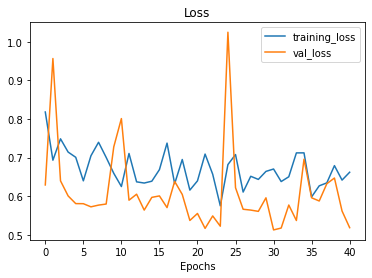

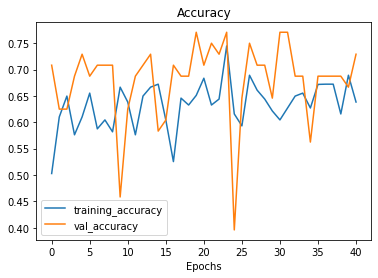

In [187]:
plot_loss_curves(resnet_history)

#### EfficientNet

In [188]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

In [189]:
efficient_model = Sequential()
efficient_model.add(base_model)
efficient_model.add(layers.Flatten())


efficient_model.add(layers.Dense(1, activation='sigmoid'))
efficient_model.layers[0].trainable = False

efficient_model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

efficient_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_19 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 62721     
Total params: 4,112,292
Trainable params: 62,721
Non-trainable params: 4,049,571
_________________________________________________________________


In [190]:
efficient_model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics=['accuracy']
)
efficient_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_19 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 62721     
Total params: 4,112,292
Trainable params: 62,721
Non-trainable params: 4,049,571
_________________________________________________________________


In [191]:
efficient_history = efficient_model.fit(
    train_generator,
    steps_per_epoch=step,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=val_step,
    callbacks=[es, efficient_mc]
)

Epoch 1/100
12/12 [==============================] - 12s 452ms/step - loss: 0.9185 - accuracy: 0.5198 - val_loss: 0.6754 - val_accuracy: 0.6042
Epoch 2/100
12/12 [==============================] - 4s 323ms/step - loss: 0.8071 - accuracy: 0.5367 - val_loss: 0.6613 - val_accuracy: 0.6458


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 3/100
12/12 [==============================] - 4s 296ms/step - loss: 0.7762 - accuracy: 0.5876 - val_loss: 0.6900 - val_accuracy: 0.6250
Epoch 4/100
12/12 [==============================] - 4s 293ms/step - loss: 0.7332 - accuracy: 0.5593 - val_loss: 0.6762 - val_accuracy: 0.6042
Epoch 5/100
12/12 [==============================] - 3s 314ms/step - loss: 0.7613 - accuracy: 0.5480 - val_loss: 0.9552 - val_accuracy: 0.6458
Epoch 6/100
12/12 [==============================] - 4s 316ms/step - loss: 0.7176 - accuracy: 0.5593 - val_loss: 0.8733 - val_accuracy: 0.6250
Epoch 7/100
12/12 [==============================] - 4s 291ms/step - loss: 0.7377 - accuracy: 0.5706 - val_loss: 0.6620 - val_accuracy: 0.6250
Epoch 8/100
12/12 [==============================] - 4s 292ms/step - loss: 0.7652 - accuracy: 0.5763 - val_loss: 0.6743 - val_accuracy: 0.6042
Epoch 9/100
12/12 [==============================] - 4s 296ms/step - loss: 0.7566 - accuracy: 0.5650 - val_loss: 0.7800 - val_accuracy: 0.3750

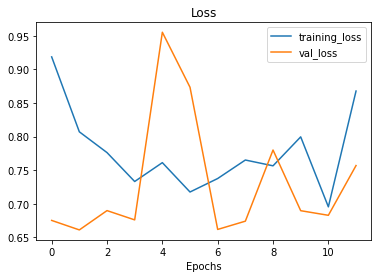

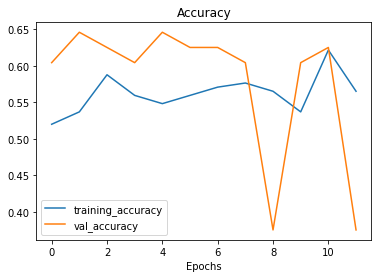

In [192]:
plot_loss_curves(efficient_history)

## Evaluation

In [193]:
import keras

In [194]:
base_model = keras.models.load_model("base_model.h5")
base_model.evaluate(X_test_prep, y_test)

1/1 [==============================] - 0s 178ms/step - loss: 1111.5096 - accuracy: 0.5000


[1111.5096435546875, 0.5]

In [195]:
vgg_model = keras.models.load_model("vgg_model.h5")
vgg_model.evaluate(X_test_prep, y_test)

1/1 [==============================] - 0s 359ms/step - loss: 3.2462 - accuracy: 0.9000


[3.246150493621826, 0.8999999761581421]

In [196]:
resnet_model = keras.models.load_model("resnet_model.h5")
resnet_model.evaluate(X_test_prep, y_test)

1/1 [==============================] - 1s 1s/step - loss: 2.0115 - accuracy: 0.5000


[2.011535882949829, 0.5]

In [197]:
efficient_model = keras.models.load_model("efficient_model.h5")
efficient_model.evaluate(X_test_prep, y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.7057 - accuracy: 0.7000


[0.7056690454483032, 0.699999988079071]

in conclusion i used vgg model for because of the prediction on unseen data is 90% of accuracy